In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

# What do we want to do? 
We’ll need to create an operational definition of the "bout:  

1.) We’ll need to set a minimum threshold over baseline in which the bout begins. 

- Let’s start with 0.001V.  
- Note: This may need to be actively adjusted per animal given variance in noise each day. 

2.) Once the threshold goes back to baseline (under threshold) we’ll have to set a minimum duration for how long it must stay under threshold for the bout to end.  

- Let’s start with 0.5 seconds.  

 

For analysis of each bout, we’ll want metrics generated for: 

1) Duration of bout 

2) Peak velocity 

3) AVG velocity 

4) Peak acceleration 

5) AVG acceleration 


# What does our data look like? 
 ‘Channel_05’ is the raw velocity and ‘Channel_05_ts_step’ is the sampling frequency (1000 Hz, i.e. 1 ms, which should be the same for all files). 'Channel_05' should be a continuous trace. 

In [77]:
voltage_cutoff = .001
minumum_duration = 30

# Import Data 
First, we're going to use the scipy function `loadmat` to import our `.mat` file. 

In [68]:
data = loadmat('WT - DAY 5.mat')

Now, let's explore our data file a little. 

In [69]:
type(data)

dict

Ok, looks our data is formatted as a dictionary, so what are the keys of this dictionary? 

In [70]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Channel_05', 'Channel_05_ind', 'Channel_05_ts', 'Channel_05_ts_step'])

In [71]:
data['Channel_05_ts']

array([[0]], dtype=uint8)

In [72]:
data['Channel_05_ts_step']

array([[0.0001]])

In [73]:
sampling_rate_hz = int(1/data['Channel_05_ts_step'][0][0])
data['Channel_05'][:sampling_rate_hz * 60].shape

(600000, 1)

Text(0, 0.5, 'Voltage')

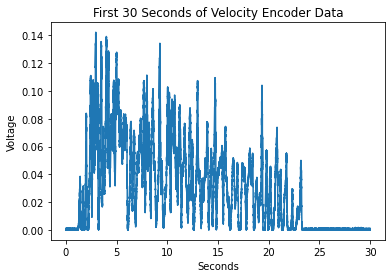

In [74]:
plt.plot(np.arange(sampling_rate_hz* 30)/sampling_rate_hz, np.abs(data['Channel_05'][:sampling_rate_hz * 30]))
plt.title('First 30 Seconds of Velocity Encoder Data')
plt.xlabel('Seconds')
plt.ylabel('Voltage')

In the plot above, we plot Voltage against Seconds, where we see a single movement bout. Let's see what happens if we just start and end a bout whenever Voltage is above .1

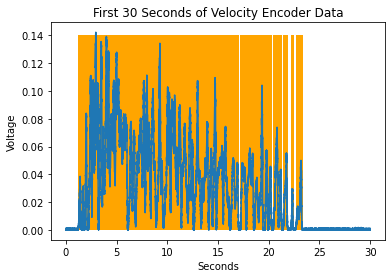

In [90]:
above_cutoff = data['Channel_05'] < -.01 #  voltage_cutoff
plt.vlines(np.arange(sampling_rate_hz * 30)[above_cutoff[:sampling_rate_hz * 30].reshape(-1)]/sampling_rate_hz, ymin = 0, ymax= .14, color = 'orange')
plt.plot(np.arange(sampling_rate_hz* 30)/sampling_rate_hz, np.abs(data['Channel_05'][:sampling_rate_hz * 30]))
plt.title('First 30 Seconds of Velocity Encoder Data')
plt.xlabel('Seconds')
plt.ylabel('Voltage')
plt.savefig('example.png')
plt.show()

That actually works pretty well, but we have to account for those small gaps - how do we do that? We need to implement the minimum length of time our velocity encoder has to fall below the threshold. This is encoded by the `minimum_duration`. To get the number of timesteps that we need to look out for, we need to multiply `minimum_duration` by `sampling_rate_hz`. Then, for every `TRUE` value in `above_cutoff` (this is a boolean array with `TRUE` if it's above the cutoff and `FALSE` if it's below), we check if the next `minimum_duration` * `sampling_rate_hz` time steps are `FALSE`. If they are, we can stop the movement epoch. If they aren't, we continue until the next `TRUE`, where we start checking again. 

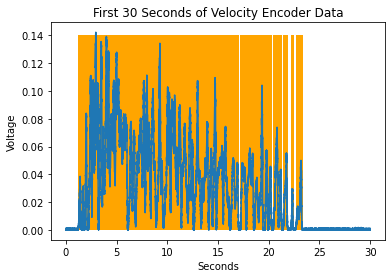

In [128]:
above_cutoff = data['Channel_05'] < -.01 #  voltage_cutoff
plt.vlines(np.arange(sampling_rate_hz * 30)[above_cutoff[:sampling_rate_hz * 30].reshape(-1)]/sampling_rate_hz, ymin = 0, ymax= .14, color = 'orange')
plt.plot(np.arange(sampling_rate_hz* 30)/sampling_rate_hz, np.abs(data['Channel_05'][:sampling_rate_hz * 30]))
plt.title('First 30 Seconds of Velocity Encoder Data')
plt.xlabel('Seconds')
plt.ylabel('Voltage')
plt.savefig('example.png')
plt.show()

In [129]:
True_followed_by_false = above_cutoff[:-1] * (1 - above_cutoff[1:]) # this gives us an array of bbolean values whenever there is a True followed by a False
indices = np.where(True_followed_by_false == 1)[0] + 1 # this converts the array of boolean values to a list of indices
for i, idx in enumerate(indices): 
    """
    We want to check if the next minumum_duration of seconds are
    all False
    """
    end_of_array = above_cutoff.shape[0] - 1
    curr_slice = above_cutoff[idx: min(idx + (minumum_duration * sampling_rate_hz), end_of_array)]
    if np.sum(curr_slice) > 10: # if there are more than 10 times it breaks the cutoff 
        if i + 1 != len(indices):
            end = min((minumum_duration * sampling_rate_hz), (indices[i + 1] - idx))
        else: 
            end = min((minumum_duration * sampling_rate_hz), len(indices) - 1)
        above_cutoff[idx: idx + end] = np.array([True] * end).reshape(-1, 1)
        


ValueError: could not broadcast input array from shape (27501,1) into shape (2306,1)

In [ ]:
plt.vlines(np.arange(sampling_rate_hz * 60)[above_cutoff[:sampling_rate_hz * 60].reshape(-1)]/sampling_rate_hz, ymin = 0, ymax= .14, color = 'orange', label = 'Bout')
plt.plot(np.arange(sampling_rate_hz* 60)/sampling_rate_hz, np.abs(data['Channel_05'][:sampling_rate_hz * 60]), label = 'Signal')
plt.title('First 30 Seconds of Velocity Encoder Data')
plt.xlabel('Seconds')
plt.ylabel('Voltage')
plt.legend()
plt.savefig('example.png')

plt.show()

In [114]:
above_cutoff.shape[0]

37418496